In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
import warnings
import seaborn as sns

## Weibull Demand Generator

In [18]:
class WeibullDemandGenerator:
   def __init__(self, num_samples, periods, k=2.0):
       self.num_samples = num_samples
       self.periods = periods
       self.k = k

   def estimate_weibull_scale(self, samples, M, n_tail_buckets=3, fixed_lambda=None):
       if fixed_lambda is not None:
           return fixed_lambda
           
       flat_samples = samples.flatten()
       tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples <= M)]
       n_at_threshold = np.sum(flat_samples == M)
       
       def neg_log_likelihood(scale):
           eps = 1e-10
           scale = max(scale, eps)
           
           uncensored = tail_samples[tail_samples < M]
           pdf_term = np.sum(np.log(eps + stats.weibull_min.pdf(
               uncensored - (M-n_tail_buckets), 
               c=self.k,
               scale=scale
           )))
           
           if n_at_threshold > 0:
               sf = stats.weibull_min.sf(n_tail_buckets - 1, c=self.k, scale=scale)
               threshold_term = n_at_threshold * np.log(eps + sf)
           else:
               threshold_term = 0
               
           return -(pdf_term + threshold_term)
       
       result = optimize.minimize_scalar(
           neg_log_likelihood, 
           bounds=(1e-6, 20), 
           method='bounded',
           options={'xatol': 1e-8}
       )

       if not result.success:
           warnings.warn(f"Scale estimation did not converge: {result.message}")
           
       return result.x

   def fit_and_sample(self, problem_params, demand_params, seed=None, fixed_lambda=None):
       if seed is not None:
           np.random.seed(seed)
       
       M = problem_params.get('censoring_threshold', 7)
       n_tail_buckets = problem_params.get('n_tail_buckets', 3)
       
       orig_samples = np.random.poisson(
           demand_params['mean'], 
           size=(self.num_samples, problem_params['n_stores'], self.periods)
       )
       
       imputed_samples = np.minimum(orig_samples, M)
       censored_mask = orig_samples >= M
       
       weibull_scale = self.estimate_weibull_scale(orig_samples, M, n_tail_buckets, fixed_lambda)
       
       n_censored = np.sum(censored_mask)
       lower_bound = stats.weibull_min.cdf(n_tail_buckets, c=self.k, scale=weibull_scale)
       uniform_samples = np.random.uniform(lower_bound, 1-1e-10, size=n_censored)
       
       censored_tails = np.floor(
           M + stats.weibull_min.ppf(uniform_samples, c=self.k, scale=weibull_scale) - n_tail_buckets
       ).astype(int)
       
       imputed_samples[censored_mask] = censored_tails
       
       return imputed_samples

In [5]:
def plot_demand_distributions(k_values, lambda_values, problem_params, demand_params, num_samples=100000):
   plt.figure(figsize=(12, 8))
   
   # Original Poisson in black dashed
   x = np.arange(0, 15)
   poisson_pmf = stats.poisson.pmf(x, mu=demand_params['mean'])
   plt.plot(x, poisson_pmf, 'k--', lw=3, label='Original Poisson')
   
   colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
   linestyles = ['-', '--', ':']
   
   for i, k in enumerate(k_values):
       generator = WeibullDemandGenerator(num_samples=num_samples, periods=1, k=k)
       for j, lmbda in enumerate(lambda_values):
           censored_data = generator.fit_and_sample(
               problem_params, 
               demand_params, 
               seed=42, 
               fixed_lambda=lmbda
           ).flatten()
           
           counts, bins = np.histogram(censored_data, bins=range(0, 16), density=True)
           bin_centers = (bins[:-1] + bins[1:]) / 2
           plt.plot(bin_centers, counts, 
                   color=colors[i],
                   linestyle=linestyles[j % 3],
                   linewidth=2,
                   label=f'k={k:.2f}, λ={lmbda:.2f}')
   
   plt.axvline(problem_params['censoring_threshold'], color='red', linestyle=':', linewidth=2, label='Censoring')
   plt.xlim(0, 15)
   plt.xlabel('Demand')
   plt.ylabel('Density')
   plt.title('Demand Distributions')
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   plt.grid(True, alpha=0.3)
   plt.tight_layout()
   plt.show()

In [ ]:
demand_params = {
   'mean': 5  # Poisson mean
}

problem_params = {
   'censoring_threshold': 8,
   'n_stores': 1,
   'n_tail_buckets': 2
}

# Example usage:
k_values = [0.8, 1.0, 1.2]
lambda_values = [1.0, 2.0, 3.0]
plot_demand_distributions(k_values, lambda_values, problem_params, demand_params)

(1000, 5, 50)


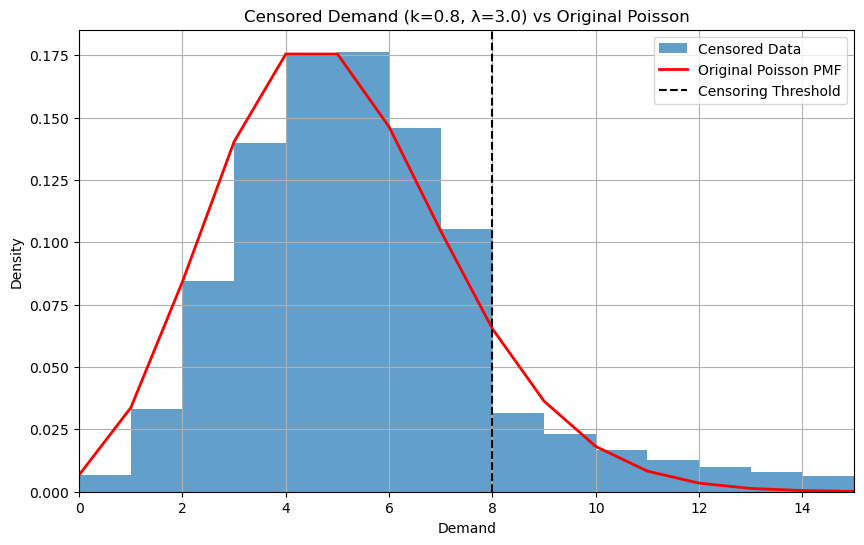

In [21]:
# Initialize generator with k close to 1
generator = WeibullDemandGenerator(num_samples=1000, periods=50, k=0.8)

# Set parameters
problem_params = {
   'censoring_threshold': 8,
   'n_stores': 5,
   'n_tail_buckets': 2
}
demand_params = {
   'mean': 5  # Poisson mean
}

# Generate censored demand with fixed lambda
fixed_lambda = 3.0  # Represent rate of the exponential distribution
censored_data = generator.fit_and_sample(problem_params, demand_params, seed=42, fixed_lambda=fixed_lambda)
print(censored_data.shape)
censored_data = censored_data.flatten()

# Create histogram of censored data
plt.figure(figsize=(10, 6))
plt.hist(censored_data, bins=range(int(min(censored_data)), int(max(censored_data)) + 2, 1), 
        density=True, alpha=0.7, label='Censored Data')

# Plot original Poisson distribution
x = np.arange(0, max(censored_data) + 1)
poisson_pmf = stats.poisson.pmf(x, mu=demand_params['mean'])
plt.plot(x, poisson_pmf, 'r-', lw=2, label='Original Poisson PMF')

plt.axvline(problem_params['censoring_threshold'], color='black', linestyle='--', label='Censoring Threshold')
plt.xlim(0, 15)
plt.xlabel('Demand')
plt.ylabel('Density')
plt.title(f'Censored Demand (k={generator.k}, λ={fixed_lambda}) vs Original Poisson')
plt.legend()
plt.grid(True)
plt.show()

## Estimating via Kaplan-Meier

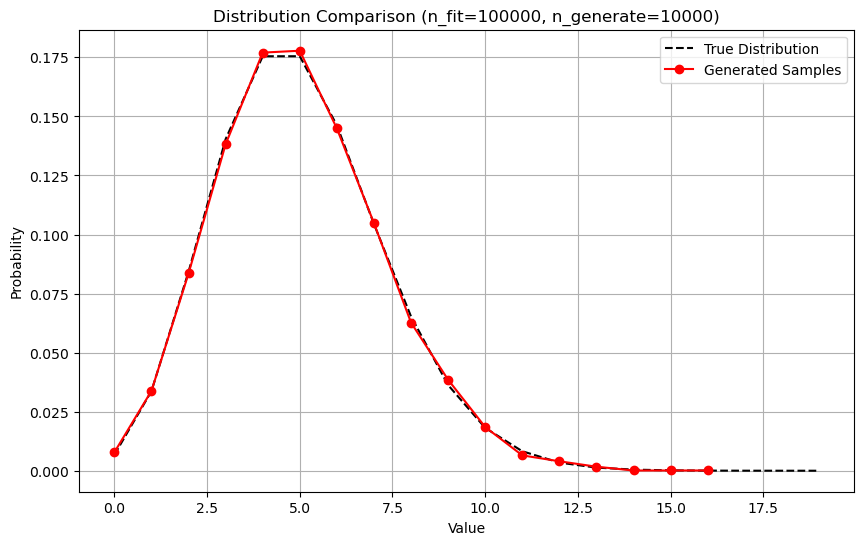

In [16]:
import numpy as np
from scipy import stats, optimize
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

class KMSampler:
    def __init__(self, num_samples, periods):
        self.kmf = None
        self.tail_rate = None
        self.max_uncensored = None
        self.num_samples = num_samples
        self.periods = periods
    
    def fit(self, observed_data, censoring_indicators, M, n_buckets=3):
        """Fit KM estimator and tail rate to data"""
        self.kmf = KaplanMeierFitter()
        self.kmf.fit(observed_data, censoring_indicators)
        
        # Get CDF values
        times = self.kmf.survival_function_.index
        cdf = 1 - self.kmf.survival_function_.values.flatten()
        
        # Get the last n_buckets points and their densities
        last_cdfs = cdf[-(n_buckets+1):]  # Get last 3 CDF values
        densities = np.diff(last_cdfs)     # Get P(X = k) for k in [M-2, M-1, M]
        p_greater_M = 1 - last_cdfs[-1]    # P(X > M)
        densities = np.append(densities, p_greater_M)
        
        # print(f"Debug - Last CDF values: {last_cdfs}")
        # print(f"Debug - Densities at last points: {densities}")
        # print(f"Debug - P(X > M): {p_greater_M}")
        
        def neg_log_likelihood(rate):
            if rate <= 0:
                return np.inf
            
            # Calculate model probabilities
            model_probs = np.array([
                np.exp(-rate * i) - np.exp(-rate * (i + 1))
                for i in range(n_buckets)
            ])
            # for last bucket, model prob is np.exp(-rate * n_buckets). need to add it to the last bucket
            model_probs = np.append(model_probs, np.exp(-rate * n_buckets))
            
            # Avoid log(0)
            valid_idx = (densities > 0) & (model_probs > 0)
            if not np.any(valid_idx):
                return np.inf
                
            return -np.sum(densities[valid_idx] * np.log(model_probs[valid_idx]))
        
        result = optimize.minimize_scalar(
            neg_log_likelihood, 
            bounds=(0.001, 2.0),
            method='bounded'
        )
        
        self.tail_rate = result.x
        self.threshold = times[-1]  # This is M
        # print(f'Estimated tail rate: {self.tail_rate}')
        
    def sample(self, n_samples):
        """Generate new samples from fitted distribution"""
        if self.kmf is None:
            raise ValueError("Must fit model before sampling")
            
        # Get survival function values
        times = np.arange(np.min(self.kmf.survival_function_.index), 
                        np.max(self.kmf.survival_function_.index) + 1)
        cdf = 1 - self.kmf.survival_function_at_times(times).values
        
        samples = np.zeros(n_samples)
        for i in range(n_samples):
            u = np.random.uniform(0, 1)
            
            # Find the smallest time where CDF is greater than u
            mask = cdf >= u
            if np.any(mask):  # Use KM distribution
                samples[i] = times[np.where(mask)[0][0]]
            else:
                # Sample from tail using threshold (M) instead of max_uncensored
                excess = np.random.exponential(1/self.tail_rate)
                samples[i] = self.threshold + np.floor(excess)

        
        return samples.astype(int)

    def fit_and_sample(self, n_fit, problem_params, demand_params, censoring_process, seed=None):
        """
        Run experiment fitting KM to n_fit samples and generating n_generate new ones
        """
        if seed is not None:
            np.random.seed(seed)
            
        # Generate training data
        true_demand = np.random.poisson(demand_params['mean'], size=n_fit)
        thresholds = np.random.poisson(censoring_process['mean'], size=n_fit)
        
        # Apply censoring
        observed = np.minimum(true_demand, thresholds)
        # Changed to use <= for correct censoring indicators
        censoring_indicators = (true_demand <= thresholds).astype(int)

        # # print the largest uncensored value (this is, only consider the values that are not censored)    
        # print(f"Largest uncensored value: {np.max(observed[censoring_indicators == 1])}")
        # print(f"Largest censored value: {np.max(observed[censoring_indicators == 0])}")

        # Fit sampler
        self.fit(observed, censoring_indicators, M=np.max(thresholds))
        
        n_generate = problem_params['n_stores'] * self.periods * self.num_samples

        # Generate new samples
        generated_samples = self.sample(n_generate)

        # reshape to self.num_samples, self.n_stores, self.periods
        generated_samples = generated_samples.reshape(self.num_samples, problem_params['n_stores'], self.periods)


        return generated_samples

def run_sampling_experiment(n_fit, n_generate, demand_params, censoring_process, seed=None):
    """
    Run experiment fitting KM to n_fit samples and generating n_generate new ones
    """
    if seed is not None:
        np.random.seed(seed)
        
    # Generate training data
    true_demand = np.random.poisson(demand_params['mean'], size=n_fit)
    thresholds = np.random.poisson(censoring_process['mean'], size=n_fit)
    
    # Apply censoring
    observed = np.minimum(true_demand, thresholds)
    # Changed to use <= for correct censoring indicators
    censoring_indicators = (true_demand <= thresholds).astype(int)

    # # print the largest uncensored value (this is, only consider the values that are not censored)    
    # print(f"Largest uncensored value: {np.max(observed[censoring_indicators == 1])}")
    # print(f"Largest censored value: {np.max(observed[censoring_indicators == 0])}")

    # Fit sampler
    sampler = KMSampler(num_samples=n_fit, periods=1)
    sampler.fit(observed, censoring_indicators, M=np.max(thresholds))
    
    # Generate new samples
    generated_samples = sampler.sample(n_generate)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    
    # True distribution
    x = np.arange(0, max(20, np.max(generated_samples)))
    plt.plot(x, stats.poisson.pmf(x, demand_params['mean']), 
             'k--', label='True Distribution')
    
    # Generated samples
    all_values = np.arange(min(generated_samples), max(generated_samples) + 1)
    counts = np.bincount(generated_samples.astype(int), 
                        minlength=max(generated_samples) + 1)[min(generated_samples):]
    plt.plot(all_values, counts/len(generated_samples), 
             'ro-', label='Generated Samples')
    
    plt.title(f'Distribution Comparison (n_fit={n_fit}, n_generate={n_generate})')
    plt.xlabel('Value')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
if __name__ == "__main__":
    demand_params = {'mean': 5}
    censoring_process = {'name': 'poisson', 'mean': 6}

    run_sampling_experiment(n_fit=100000, n_generate=10000, 
                          demand_params=demand_params, 
                          censoring_process=censoring_process,
                          seed=42)

In [17]:
km_sampler = KMSampler(num_samples=1000, periods=50)

problem_params = {'n_stores': 5}
demand_params = {'mean': 5}
censoring_process = {'name': 'poisson', 'mean': 6}
n_fit = 10000 # samples to fit the KM (equals to samples*periods*n_stores of the fictituous setting were data was gathered)

samples = km_sampler.fit_and_sample(n_fit, problem_params, demand_params, censoring_process, seed=42)
print(samples.shape)

(1000, 5, 50)


In [ ]:
import matplotlib.pyplot as plt

# Define the vectors
vector1 = [0.99342, 0.96007676, 0.87595408, 0.73728814, 0.56353113, 0.38665292,
            0.23893996, 0.13357496, 0.07033508, 0.03359873, 0.01292259, 0.00574337,
            0.00287169]
vector2 = [0.99326205, 0.95957232, 0.87534798, 0.73497408, 0.55950671, 0.38403935,
            0.23781654, 0.13337167, 0.06809363, 0.03182806, 0.01369527, 0.00545309,
            0.00201885]

# Plot the vectors
plt.figure(figsize=(10, 6))
plt.plot(vector1, label='Vector 1', marker='o')
plt.plot(vector2, label='Vector 2', marker='o')
plt.title('Comparison of Two Vectors')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# Old Kaplan-Meier

In [46]:
import numpy as np
from scipy import stats, optimize
from lifelines import KaplanMeierFitter

class DynamicCensoringDemandGenerator:
    def __init__(self, num_samples, periods):
        self.num_samples = num_samples
        self.periods = periods
        
    def estimate_exponential_tail_rate(self, samples, censoring_indicators, M, n_buckets=3):
        flat_samples = samples.flatten()
        tail_samples = flat_samples[(flat_samples >= M-n_buckets) & (flat_samples <= M)]
        n_at_threshold = np.sum(flat_samples == M)
        
        def neg_log_likelihood(rate):
            uncensored = tail_samples[tail_samples < M]
            pdf_term = np.sum(np.log(stats.expon.pdf(
                uncensored - (M-n_buckets), 
                scale=1/rate
            )))
            
            if n_at_threshold > 0:
                threshold_term = n_at_threshold * np.log(stats.expon.sf(
                    n_buckets - 1,
                    scale=1/rate
                ))
            else:
                threshold_term = 0
                
            return -(pdf_term + threshold_term)
        
        result = optimize.minimize_scalar(
            neg_log_likelihood,
            bounds=(0.01, 10),
            method='bounded'
        )
        
        return result.x
        
    def generate_censored_demand(self, problem_params, demand_params, censoring_process, seed=None):
        if seed is not None:
            np.random.seed(seed)
            
        # Generate true demand
        true_demand = np.random.poisson(
            demand_params['mean'],
            size=(self.num_samples, problem_params['n_stores'], self.periods)
        )
        
        # Generate censoring thresholds using the provided process
        if censoring_process['name'] == 'uniform':
            thresholds = np.random.randint(
                censoring_process['low'],
                censoring_process['high'] + 1,
                size=(self.num_samples, problem_params['n_stores'], self.periods)
            )
        elif censoring_process['name'] == 'poisson':
            thresholds = np.random.poisson(
                censoring_process['mean'],
                size=(self.num_samples, problem_params['n_stores'], self.periods)
            )
        else:
            raise ValueError("Unsupported censoring process")
            
        # Apply censoring
        observed_demand = np.minimum(true_demand, thresholds)
        censoring_indicators = (true_demand <= thresholds).astype(int)
        
        # Flatten arrays for KM estimation
        flat_observed = observed_demand.flatten()
        flat_indicators = censoring_indicators.flatten()
        
        # Fit Kaplan-Meier
        kmf = KaplanMeierFitter()
        kmf.fit(flat_observed, flat_indicators)
        
        # Initialize imputed demand with observed values
        imputed_demand = observed_demand.copy()
        
        # Create mask for censored values
        censored_mask = (censoring_indicators == 0)
        n_censored = np.sum(censored_mask)
        
        if n_censored > 0:
            thresholds_censored = thresholds[censored_mask]
            survivor_probs = kmf.predict(thresholds_censored)
            
            # For points where KM estimate exists
            valid_probs = survivor_probs > 0
            if np.any(valid_probs):
                conditional_u = np.random.uniform(0, 1, size=np.sum(valid_probs))
                scaled_u = survivor_probs[valid_probs] * conditional_u
                # Find the time point where survival function equals scaled_u
                possible_times = np.arange(np.min(flat_observed), np.max(flat_observed) + 1)
                survival_probs = kmf.survival_function_at_times(possible_times).values
                imputed_values = np.array([possible_times[survival_probs <= u][-1] if any(survival_probs <= u) 
                                         else possible_times[-1] for u in scaled_u])
                imputed_demand[censored_mask][valid_probs] = np.maximum(
                    np.ceil(imputed_values),
                    thresholds_censored[valid_probs][:]
                )
            
            # For points beyond KM support or where survival probability is 0
            if np.any(~valid_probs):
                M = np.max(thresholds)
                tail_rate = self.estimate_exponential_tail_rate(flat_observed, flat_indicators, M)
                tail_excess = np.random.exponential(1/tail_rate, size=np.sum(~valid_probs))
                imputed_demand[censored_mask][~valid_probs] = np.maximum(
                    thresholds_censored[~valid_probs][:],
                    thresholds_censored[~valid_probs][:] + np.ceil(tail_excess)
                )
         # make integer using np.floor       
        return np.floor(imputed_demand)
    

In [129]:
# Example usage
if __name__ == "__main__":
    # Parameters
    problem_params = {
        'n_stores': 5
    }
    
    demand_params = {
        'mean': 10  # Mean for demand Poisson process
    }
    
    # Example with uniform censoring
    censoring_uniform = {
        'name': 'uniform',
        'low': 5,
        'high': 15
    }
    
    # Example with Poisson censoring
    censoring_poisson = {
        'name': 'poisson',
        'mean': 8
    }

# Create generator
generator = DynamicCensoringDemandGenerator(num_samples=1000, periods=12)

# Generate with uniform censoring
uniform_results = generator.generate_censored_demand(
    problem_params,
    demand_params,
    censoring_uniform,
    seed=42
)

# Generate with Poisson censoring
poisson_results = generator.generate_censored_demand(
    problem_params,
    demand_params,
    censoring_poisson,
    seed=42
)

In [ ]:

def plot_density_comparison(sample_sizes, demand_params, censoring_process, seed=42):
    """Plot densities of imputed demands for different sample sizes"""
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("husl", len(sample_sizes))
    
    # Plot true Poisson PMF
    x = np.arange(0, 20)
    pmf = stats.poisson.pmf(x, demand_params['mean'])
    plt.plot(x, pmf, 'k--', label='True Poisson', linewidth=2)
    
    # Generate and plot for each sample size
    for size, color in zip(sample_sizes, colors):
        # Create generator
        generator = DynamicCensoringDemandGenerator(num_samples=size, periods=1)
        
        # Generate data
        imputed = generator.generate_censored_demand(
            {'n_stores': 1},
            demand_params,
            censoring_process,
            seed=seed
        )
        
        # Plot kernel density
        sns.kdeplot(imputed.flatten(), label=f'n={size}', color=color)
    
    plt.title('Density Comparison: True vs Imputed Demand')
    plt.xlabel('Demand')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
sample_sizes = [100, 1000, 100000]
demand_params = {'mean': 5}
censoring_process = {
    'name': 'poisson',
    'mean': 4
}

plot_density_comparison(sample_sizes, demand_params, censoring_process)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_density_comparison(sample_sizes, demand_params, censoring_process, seed=42):
    """Plot PMFs of imputed demands for different sample sizes"""
    plt.figure(figsize=(12, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_sizes)))
    
    # Plot true Poisson PMF
    x = np.arange(0, 20)
    pmf = stats.poisson.pmf(x, demand_params['mean'])
    plt.plot(x, pmf, 'k--', label='True Poisson', linewidth=2)
    
    # Generate and plot for each sample size
    for size, color in zip(sample_sizes, colors):
        # Create generator
        generator = DynamicCensoringDemandGenerator(num_samples=size, periods=1)
        
        # Generate data
        imputed = generator.generate_censored_demand(
            {'n_stores': 1},
            demand_params,
            censoring_process,
            seed=seed
        )
        
        # Calculate empirical PMF
        values, counts = np.unique(imputed, return_counts=True)
        empirical_pmf = counts / len(imputed.flatten())
        plt.plot(values, empirical_pmf, 'o-', label=f'n={size}', color=color)
    
    plt.title('PMF Comparison: True vs Imputed Demand')
    plt.xlabel('Demand')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_diagnostics(sample_size, demand_params, censoring_process, seed=42):
    """Plot diagnostic information about the imputation process"""
    generator = DynamicCensoringDemandGenerator(num_samples=sample_size, periods=1)
    
    # Generate true demand and censoring
    true_demand = np.random.poisson(
        demand_params['mean'],
        size=(sample_size, 1, 1)
    )
    
    if censoring_process['name'] == 'poisson':
        thresholds = np.random.poisson(
            censoring_process['mean'],
            size=(sample_size, 1, 1)
        )
    
    observed = np.minimum(true_demand, thresholds)
    censored = (true_demand > thresholds)
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.hist(true_demand.flatten(), bins=20, density=True, alpha=0.5, label='True')
    plt.hist(observed.flatten(), bins=20, density=True, alpha=0.5, label='Observed')
    plt.title('True vs Observed')
    plt.legend()
    
    plt.subplot(132)
    plt.scatter(true_demand[censored], thresholds[censored], alpha=0.1)
    plt.plot([0, 20], [0, 20], 'r--')
    plt.title('Censored Points\nTrue Demand vs Threshold')
    
    plt.subplot(133)
    plt.hist(thresholds.flatten(), bins=20, density=True)
    plt.title('Censoring Thresholds')
    
    plt.tight_layout()
    plt.show()

# Example usage
sample_sizes = [100, 1000, 10000]
demand_params = {'mean': 5}
censoring_process = {
    'name': 'poisson',
    'mean': 4
}

plot_density_comparison(sample_sizes, demand_params, censoring_process)
plot_diagnostics(1000, demand_params, censoring_process)

## Poisson Demand Generator (old)

In [44]:


class PoissonDemandGenerator:
    def __init__(self, num_samples, periods):
        """
        Initialize the demand generator
        
        Parameters:
        -----------
        num_samples : int
            Number of sample iterations
        periods : int
            Number of periods in each sample
        """
        self.num_samples = num_samples
        self.periods = periods

    def estimate_exponential_tail_rate(self, samples, M, n_tail_buckets=3):
        """
        Estimate exponential tail rate using buckets including censoring threshold
        """
        flat_samples = samples.flatten()
        
        # Include samples in window [M-n_tail_buckets, M]
        tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples <= M)]
        
        # Count samples at threshold M
        n_at_threshold = np.sum(flat_samples == M)
        
        def neg_log_likelihood(rate):
            # For uncensored observations (x < M)
            uncensored = tail_samples[tail_samples < M]
            pdf_term = np.sum(np.log(stats.expon.pdf(
                uncensored - (M-n_tail_buckets), 
                scale=1/rate
            )))
            
            # For observations at threshold (x = M)
            if n_at_threshold > 0:
                threshold_term = n_at_threshold * np.log(stats.expon.sf(
                    n_tail_buckets - 1,
                    scale=1/rate
                ))
            else:
                threshold_term = 0
                
            return -(pdf_term + threshold_term)
        
        result = optimize.minimize_scalar(
            neg_log_likelihood, 
            bounds=(0.01, 10), 
            method='bounded'
        )
        
        return result.x

    def estimate_exponential_tail_rate_old(self, samples, M, n_tail_buckets=3):
        """
        Estimate exponential tail rate using the last few buckets before censoring
        
        Parameters:
        -----------
        samples : array
            Observed samples
        M : int
            Censoring threshold
        n_tail_buckets : int, optional
            Number of buckets to use for rate estimation
        
        Returns:
        --------
        float: Estimated exponential tail rate
        """
        # Flatten samples if multidimensional
        flat_samples = samples.flatten()
        
        # Filter samples in the tail region before censoring
        tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples < M)]
        
        # Fit exponential distribution to these samples
        def neg_log_likelihood(rate):
            return -np.sum(np.log(stats.expon.pdf(tail_samples - (M-n_tail_buckets), scale=1/rate)))
        
        # Optimize to find the rate that minimizes negative log-likelihood
        result = optimize.minimize_scalar(neg_log_likelihood, bounds=(0.01, 10), method='bounded')
        
        return result.x

    def generate_censored_demand(self, problem_params, demand_params, seed=None):
        """
        Generate Poisson demand with censoring and exponential tail imputation
        
        Parameters:
        -----------
        problem_params : dict
            Parameters defining the problem, including censoring threshold
        demand_params : dict
            Parameters for demand generation (e.g., mean)
        seed : int, optional
            Random seed for reproducibility
        
        Returns:
        --------
        numpy.ndarray: Censored and imputed demand samples
        """
        # Set seed
        if seed is not None:
            np.random.seed(seed)
        
        # Extract censoring threshold
        M = problem_params.get('censoring_threshold', 7)
        
        # Generate original Poisson samples
        orig_samples = np.random.poisson(
            demand_params['mean'], 
            size=(self.num_samples, problem_params['n_stores'], self.periods)
        )
        
        # Create a copy for tail imputation
        imputed_samples = np.minimum(orig_samples, M)
        
        # Identify which samples were censored
        censored_mask = orig_samples >= M
        
        # Estimate exponential tail rate (across all samples)
        lambda_exp = self.estimate_exponential_tail_rate(orig_samples, M)
        
        # Generate exponential samples for censored values
        censored_tails = np.floor(
            M + np.random.exponential(1/lambda_exp, size=np.sum(censored_mask))
        ).astype(int)
        
        # Replace censored values with imputed tail samples
        imputed_samples[censored_mask] = censored_tails
        
        return imputed_samples

In [ ]:
# Example usage
num_samples = 10000
periods = 10
demand_generator = PoissonDemandGenerator(num_samples, periods)

problem_params = {
    'n_stores': 5,
    'censoring_threshold': 5
}

demand_params = {
    'mean': 5
}

censored_demand = demand_generator.generate_censored_demand(problem_params, demand_params)

plt.hist(censored_demand.flatten(), bins=range(15), density=True, alpha=0.5, label='Censored Demand')

# Plot the PDF of the original Poisson demand
x = np.arange(0, 15)
poisson_pmf = stats.poisson.pmf(x, demand_params['mean'])
plt.plot(x, poisson_pmf, 'r-', label='Original Poisson PDF')

plt.legend()
plt.xlabel('Demand')
plt.ylabel('Density')
plt.title('Censored Demand and Original Poisson PDF')
plt.show()

In [ ]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def estimate_exponential_tail_rate(samples, M, n_tail_buckets=3):
    """
    Estimate exponential tail rate using the last few buckets before censoring
    """
    # Filter samples in the tail region before censoring
    tail_samples = samples[(samples >= M-n_tail_buckets) & (samples < M)]
    
    # Fit exponential distribution to these samples
    def neg_log_likelihood(rate):
        return -np.sum(np.log(stats.expon.pdf(tail_samples - (M-n_tail_buckets), scale=1/rate)))
    
    # Optimize to find the rate that minimizes negative log-likelihood
    result = optimize.minimize_scalar(neg_log_likelihood, bounds=(0.01, 10), method='bounded')
    
    return result.x

def generate_and_impute(lambda_poisson, M, n_samples=10000, seed=42, n_tail_buckets=3):
    """
    Generate Poisson samples, censor at M, and impute exponential tail
    with rate estimated from observed data
    """
    np.random.seed(seed)
    
    # Generate Poisson samples
    orig_samples = np.random.poisson(lambda_poisson, n_samples)
    
    # Censor samples at M
    censored_samples = np.minimum(orig_samples, M)
    
    # Identify which samples were censored
    censored_mask = orig_samples >= M
    
    # Estimate exponential tail rate from observed data
    lambda_exp = estimate_exponential_tail_rate(orig_samples, M, n_tail_buckets)
    
    # Generate tail samples
    tail_samples = censored_samples.astype(int)
    
    # Impute censored samples using exponential distribution
    # Start imputation from M and add exponential samples
    censored_indices = np.where(censored_mask)[0]
    tail_samples[censored_indices] = np.round(
        M + np.random.exponential(1/lambda_exp, sum(censored_mask))
    ).astype(int)
    
    return {
        'original_samples': orig_samples,
        'censored_samples': censored_samples,
        'tail_imputed_samples': tail_samples,
        'estimated_tail_rate': lambda_exp,
        'censoring_rate': np.mean(censored_mask)
    }

def visualize_results(results):
    """
    Visualize the distribution of original, censored, and imputed samples
    """
    plt.figure(figsize=(15, 5))
    
    # Original distribution
    plt.subplot(1, 3, 1)
    plt.hist(results['original_samples'], bins=range(int(max(results['original_samples']))+2), alpha=0.7, color='blue')
    plt.title('Original Poisson Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Censored distribution
    plt.subplot(1, 3, 2)
    plt.hist(results['censored_samples'], bins=range(int(max(results['censored_samples']))+2), alpha=0.7, color='red')
    plt.title('Censored Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Tail Imputed distribution
    plt.subplot(1, 3, 3)
    plt.hist(results['tail_imputed_samples'], bins=range(int(max(results['tail_imputed_samples']))+2), alpha=0.7, color='green')
    plt.title('Tail Imputed Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    # Print out value counts to check probabilities
    print("\nValue Counts:")
    unique, counts = np.unique(results['tail_imputed_samples'], return_counts=True)
    for val, count in zip(unique, counts):
        print(f"Value {val}: {count/len(results['tail_imputed_samples'])*100:.2f}%")
    
    print(f"\nEstimated Tail Rate: {results['estimated_tail_rate']:.4f}")

# Example usage
lambda_poisson = 5  # Poisson rate
M = 7  # Censoring threshold

# decorate to allow zooming in
results = generate_and_impute(lambda_poisson, M)
visualize_results(results)

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def generate_and_impute(lambda_poisson, M, n_samples=10000, seed=42):
    """
    Generate Poisson samples, censor at M, and impute exponential tail
    
    Parameters:
    -----------
    lambda_poisson : float
        Rate parameter for Poisson distribution
    M : int
        Censoring threshold
    n_samples : int, optional
        Number of samples to generate
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    dict containing original samples, censored samples, and imputed samples
    """
    # Set random seed
    np.random.seed(seed)
    
    # Generate Poisson samples
    orig_samples = np.random.poisson(lambda_poisson, n_samples)
    
    # Censor samples at M
    censored_samples = np.minimum(orig_samples, M)
    
    # Identify which samples were censored
    censored_mask = orig_samples >= M
    
    # Estimate exponential rate for tail
    # For censored samples, we know the true rate should equal the Poisson rate
    # This is a key insight when the underlying distribution is known
    lambda_exp = lambda_poisson
    
    # Generate tail samples for censored observations
    tail_samples = np.zeros(n_samples)
    tail_samples[~censored_mask] = censored_samples[~censored_mask]
    tail_samples[censored_mask] = M + np.random.exponential(1/lambda_exp, sum(censored_mask))
    # make samples integers
    tail_samples = np.round(tail_samples).astype(int)
    
    return {
        'original_samples': orig_samples,
        'censored_samples': censored_samples,
        'tail_imputed_samples': tail_samples,
        'censoring_rate': np.mean(censored_mask)
    }

def visualize_results(results):
    """
    Visualize the distribution of original, censored, and imputed samples
    """
    plt.figure(figsize=(12, 5))
    
    # Original distribution
    plt.subplot(1, 3, 1)
    plt.hist(results['original_samples'], bins=50, alpha=0.7, color='blue')
    plt.title('Original Poisson Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Censored distribution
    plt.subplot(1, 3, 2)
    plt.hist(results['censored_samples'], bins=50, alpha=0.7, color='red')
    plt.title('Censored Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Tail Imputed distribution
    plt.subplot(1, 3, 3)
    plt.hist(results['tail_imputed_samples'], bins=50, alpha=0.7, color='green')
    plt.title('Tail Imputed Samples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Example usage
lambda_poisson = 5  # Poisson rate
M = 10  # Censoring threshold

results = generate_and_impute(lambda_poisson, M)
visualize_results(results)

# Print some statistics
print(f"Censoring rate: {results['censoring_rate']*100:.2f}%")
print(f"Original mean: {np.mean(results['original_samples']):.2f}")
print(f"Censored mean: {np.mean(results['censored_samples']):.2f}")
print(f"Imputed mean: {np.mean(results['tail_imputed_samples']):.2f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, expon

def generate_truncated_poisson_with_tail(lambda_poisson, M, size):
    """
    Generates data from a Poisson distribution truncated at M, 
    with an exponential tail starting at M.

    Parameters:
        lambda_poisson (float): Rate parameter for the Poisson distribution.
        M (int): Truncation value.
        size (int): Total number of samples to generate.

    Returns:
        np.array: Array of generated samples.
        float: Rate of the exponential tail.
    """
    # Generate Poisson samples
    poisson_samples = np.random.poisson(lambda_poisson, size)
    
    # Truncate Poisson samples at M
    truncated_samples = poisson_samples[poisson_samples <= M]
    
    # Calculate remaining samples needed
    n_remaining = size - len(truncated_samples)
    
    # Calculate the probability mass beyond M
    prob_mass_beyond_M = 1 - poisson.cdf(M, lambda_poisson)
    
    # Define the rate of the exponential tail
    lambda_exp = prob_mass_beyond_M / (1 / lambda_poisson)
    
    # Ensure the exponential tail density does not exceed the Poisson density at M
    poisson_density_at_M = poisson.pmf(M, lambda_poisson)
    max_exp_density = lambda_exp
    if max_exp_density > poisson_density_at_M:
        lambda_exp = poisson_density_at_M
    
    # Generate values for the exponential tail
    if n_remaining > 0:
        exp_tail = M + np.random.exponential(1 / lambda_exp, n_remaining)
    else:
        exp_tail = np.array([])

    # Combine and return
    return np.concatenate([truncated_samples, exp_tail]), lambda_exp

# Parameters
lambda_poisson = 5  # Rate of the Poisson distribution
M = 10              # Truncation value
size = 10000        # Number of samples

# Generate data
data, lambda_exp = generate_truncated_poisson_with_tail(lambda_poisson, M, size)

# Plot histogram
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Generated Data')

# Plot original Poisson density
x = np.arange(0, M + 20)
poisson_pmf = poisson.pmf(x, lambda_poisson)
plt.plot(x, poisson_pmf, 'b-', label='Original Poisson PMF')

# Plot exponential tail density
x_tail = np.linspace(M, M + 20, 1000)
exp_density = lambda_exp * np.exp(-lambda_exp * (x_tail - M))
plt.plot(x_tail, exp_density, 'r--', label='Exponential Tail Density')

plt.axvline(M, color='black', linestyle='--', label='Truncation Point (M)')
plt.title("Truncated Poisson Distribution with Exponential Tail")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Print the estimated rate of the exponential tail
print(f"Estimated rate of exponential tail: {lambda_exp:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def sample_censored_demand(n_samples, lambda_demand, truncation_value):
    """
    Sample from a censored demand distribution with normalized tail.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    lambda_demand : float
        Mean of the Poisson distribution for original demand
    truncation_value : float
        Value at which demand is censored
    
    Returns:
    --------
    numpy.ndarray
        Sampled demand values
    float
        Proportion of samples above truncation value
    """
    # Generate initial Poisson samples
    poisson_samples = np.random.poisson(lambda_demand, n_samples)
    
    # Calculate the proportion of samples above truncation value
    prop_censored = np.mean(poisson_samples >= truncation_value)
    
    # Create mask for censored (truncated) samples
    censored_mask = poisson_samples >= truncation_value
    
    # Preserve the original discrete Poisson distribution up to truncation_value
    censored_samples = poisson_samples.copy()
    
    # For censored samples, use geometric tail distribution
    # This ensures remaining probability mass is distributed proportionally
    n_censored = np.sum(censored_mask)
    
    # Geometric tail parameters
    tail_base = 1.2  # Can be adjusted to control tail behavior
    tail_samples = (
        truncation_value + 
        np.floor(np.random.geometric(1/tail_base, n_censored))
    )
    
    # Replace censored samples
    censored_samples[censored_mask] = tail_samples
    
    return censored_samples, prop_censored

def plot_demand_distributions(lambda_demand, truncation_value, n_samples=10000):
    """
    Plot original and imputed demand distributions.
    
    Parameters:
    -----------
    lambda_demand : float
        Mean of the Poisson distribution
    truncation_value : float
        Value at which demand is censored
    n_samples : int, optional
        Number of samples to generate
    """
    # Sample demands and get censored proportion
    samples, prop_censored = sample_censored_demand(
        n_samples, 
        lambda_demand, 
        truncation_value
    )
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Original Poisson distribution
    x_poisson = np.arange(0, max(samples) + 5)
    poisson_pmf = stats.poisson.pmf(x_poisson, lambda_demand)
    
    # Modify PMF to match truncation
    poisson_pmf_truncated = poisson_pmf.copy()
    norm_factor = 1 - np.sum(poisson_pmf[poisson_pmf.shape[0] >= truncation_value])
    poisson_pmf_truncated[poisson_pmf_truncated.shape[0] >= truncation_value] = 0
    poisson_pmf_truncated /= np.sum(poisson_pmf_truncated)
    
    # Plot original PMF
    plt.bar(x_poisson[:truncation_value], 
            poisson_pmf_truncated[:truncation_value], 
            alpha=0.5, label='Original Poisson PMF', color='blue')
    
    # Histogram of imputed samples
    plt.hist(samples, bins=50, density=True, alpha=0.7, 
             label='Imputed Samples', color='red')
    
    plt.title(f'Demand Distribution\nPoisson(λ={lambda_demand}), Truncation={truncation_value}\nProportion Censored: {prop_censored:.4f}')
    plt.xlabel('Demand')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return samples, prop_censored

# Example usage
lambda_demand = 5  # Poisson mean
truncation_value = 7  # Censoring threshold

# Demonstrate sampling and plotting
samples, prop_censored = plot_demand_distributions(lambda_demand, truncation_value)

# Additional analysis
print(f"Proportion of samples censored: {prop_censored:.4f}")
print(f"Mean of original Poisson: {lambda_demand}")
print(f"Mean of imputed samples: {np.mean(samples)}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def sample_censored_demand(n_samples, lambda_demand, truncation_value, exponential_rate):
    """
    Sample from a censored demand distribution with exponential tail.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    lambda_demand : float
        Mean of the Poisson distribution for original demand
    truncation_value : float
        Value at which demand is censored
    exponential_rate : float
        Rate parameter for the exponential tail distribution
    
    Returns:
    --------
    numpy.ndarray
        Sampled demand values
    """
    # Generate initial Poisson samples
    poisson_samples = np.random.poisson(lambda_demand, n_samples)
    
    # Create mask for censored (truncated) samples
    censored_mask = poisson_samples >= truncation_value
    
    # Create output samples
    censored_samples = poisson_samples.copy()
    
    # For censored samples, add exponential tail to truncation value
    censored_samples[censored_mask] = (
        truncation_value + 
        np.random.exponential(1/exponential_rate, np.sum(censored_mask))
    )
    
    return censored_samples

def plot_demand_distributions(lambda_demand, truncation_value, exponential_rate, n_samples=10000):
    """
    Plot original and imputed demand distributions.
    
    Parameters:
    -----------
    lambda_demand : float
        Mean of the Poisson distribution
    truncation_value : float
        Value at which demand is censored
    exponential_rate : float
        Rate parameter for exponential tail distribution
    n_samples : int, optional
        Number of samples to generate
    """
    # Sample demands
    samples = sample_censored_demand(n_samples, lambda_demand, truncation_value, exponential_rate)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Original Poisson distribution
    x_poisson = np.arange(0, truncation_value + 10)
    poisson_pmf = stats.poisson.pmf(x_poisson, lambda_demand)
    
    # Modify PMF to match truncation
    poisson_pmf_truncated = poisson_pmf.copy()
    poisson_pmf_truncated[poisson_pmf_truncated.shape[0] >= truncation_value] = 0
    poisson_pmf_truncated /= np.sum(poisson_pmf_truncated)
    
    # Plot original PMF
    plt.bar(x_poisson[:truncation_value], 
            poisson_pmf_truncated[:truncation_value], 
            alpha=0.5, label='Original Poisson PMF', color='blue')
    
    # Histogram of imputed samples
    plt.hist(samples, bins=50, density=True, alpha=0.7, 
             label='Imputed Samples', color='red')
    
    plt.title(f'Demand Distribution\nPoisson(λ={lambda_demand}), Truncation={truncation_value}, Exp Rate={exponential_rate}')
    plt.xlabel('Demand')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return samples

# Example usage
lambda_demand = 5  # Poisson mean
truncation_value = 7  # Censoring threshold
exponential_rate = 0.5  # Rate for exponential tail

# Demonstrate sampling and plotting
samples = plot_demand_distributions(lambda_demand, truncation_value, exponential_rate)

# Additional analysis
print(f"Mean of original Poisson: {lambda_demand}")
print(f"Mean of imputed samples: {np.mean(samples)}")
print(f"Proportion of samples above truncation: {np.mean(samples >= truncation_value):.4f}")